<a href="https://colab.research.google.com/github/sirius70/NLP_HW4/blob/main/IE7275_Module3_Part2_STUDENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IE7275 Data Mining in Engineering**
### -- STUDENT VERSION --

---
#### **Guidelines for Completing and Submitting This Notebook**

Please follow these instructions carefully. Completing all parts of this notebook is required to receive full credit:

#### **You must:**
- **Answer all questions** and reflection tasks using your own words.
- **Summarize every reflection task** clearly and completely.
- **Fill out all missing code cells** — do not leave any code blocks empty.
- **Run your notebook** to ensure that all outputs and visualizations are generated and visible.
- **Convert your completed notebook** to **PDF** or **HTML** format before submission.
- **Submit the file to Canvas** before the deadline.

#### **Academic Integrity Reminder**:
- You must complete this notebook individually.
- Do not copy answers or code from classmates, online sources, or use tools like **ChatGPT** or other **AI writing or code generation tools**.
- Keep in mind that if you use such tools, your answer may be **identical or highly similar** to others who do the same — in this case, we will treat it as copying and apply a **50% penalty** to your assignment grade.

By submitting this notebook, you confirm that all work is your own and that you have followed these guidelines.


---



## **Module 3: Data Preprocessing and Cleaning (Part 2)**

#### **Module 3.12: Pipeline Construction for Data Transformation**

In real-world machine learning projects, preprocessing often involves multiple steps such as handling missing values, scaling numeric features, encoding categorical variables, and performing feature selection. Managing these steps manually can be error-prone and difficult to reproduce. **Pipelines** in scikit-learn provide a systematic way to chain these transformations with model training into a single, organized workflow.

#### **Why Pipelines Matter**
Without a pipeline, there is a risk of applying inconsistent preprocessing between the training and testing datasets, leading to **data leakage** and overly optimistic model performance. A pipeline ensures that the **exact same sequence of transformations** is applied consistently, preserving the integrity of your evaluation and deployment process.

#### **Benefits of Using Pipelines**
- **Consistency**: Guarantees the same preprocessing steps for both training and inference.
- **Maintainability**: Combines all steps into one object, making code cleaner and easier to debug.
- **Reproducibility**: Ensures results can be replicated exactly by saving the full pipeline.
- **Hyperparameter Optimization**: Works seamlessly with `GridSearchCV` or `RandomizedSearchCV` to tune preprocessing and model parameters together.
- **Deployment Readiness**: The entire transformation and prediction process can be serialized and loaded in production environments.

#### **Mathematical Representation**
A pipeline can be seen as a composition of transformations $( T_1, T_2, \dots, T_k )$ followed by a final estimator $( M )$:

$
\hat{y} = M \left( T_k \left( T_{k-1} \left( \dots T_1(X) \dots \right) \right) \right)
$

Where:
- $ X $ is the input feature matrix.
- $ T_i $ represents a preprocessing transformation (e.g., scaling, encoding, feature selection).
- $ M $ is the machine learning model producing predictions $(\hat{y})$.

#### **Typical Pipeline Steps**
1. **Data Cleaning** — Handle missing values (imputation), correct inconsistencies.
2. **Feature Transformation** — Scale numerical features (StandardScaler, MinMaxScaler), encode categorical features (OneHotEncoder).
3. **Feature Selection or Extraction** — Remove irrelevant features or reduce dimensionality (PCA, SelectKBest).
4. **Model Training** — Fit a predictive model using the transformed features.

#### **Important Considerations**
- The order of steps matters: transformations must be applied in the correct sequence to avoid invalid inputs for later steps.
- All preprocessing in a pipeline should be **fit only on the training data** to prevent data leakage.
- Pipelines can handle both numerical and categorical features via **ColumnTransformer**, allowing different transformations for each feature subset.
- For deployment, save the entire pipeline object so that preprocessing and modeling remain synchronized.

---


#### **Exercise 1: Building a Complete Machine Learning Pipeline with Preprocessing and Classification**

**Objective:**  
Learn how to build a full preprocessing and modeling pipeline using scikit-learn’s `Pipeline` and `ColumnTransformer`. This exercise will help you organize your workflow by combining imputation, scaling, encoding, and classification into a single, reusable object. You'll also learn to apply the pipeline consistently to training and test data.

**Instructions:**  
1. Load a sample dataset (e.g., `titanic` or `adult` dataset with both numeric and categorical columns).
2. Separate the features into numeric and categorical groups.
3. For numeric columns:
   - Use `SimpleImputer` to fill missing values with the mean.
   - Apply `StandardScaler` to standardize features.
4. For categorical columns:
   - Use `SimpleImputer` to fill missing values with the most frequent value.
   - Apply `OneHotEncoder` to convert categories to binary variables.
5. Use `ColumnTransformer` to combine both transformations.
6. Create a `Pipeline` that includes:
   - The `ColumnTransformer` as the preprocessing step.
   - A classifier (e.g., `LogisticRegression` or `RandomForestClassifier`) as the final estimator.
7. Split the data into training and test sets.
8. Fit the pipeline on the training data and evaluate it on the test data.
9. Print accuracy, classification report, and inspect pipeline steps.

This exercise demonstrates how pipelines can simplify complex workflows, avoid data leakage, and prepare you for model deployment and tuning.

---

In [1]:
# Step 1: Load libraries and data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns

# Load Titanic dataset from seaborn
df = sns.load_dataset("titanic")

df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
# Step 2: Select features and target
features = ['age', 'fare', 'embarked', 'sex', 'class']
target = 'survived'

X = df[features]
y = df[target]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Step 4: Define preprocessing pipelines
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['embarked', 'sex', 'class']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Step 5: Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Create full pipeline with classifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [4]:
# Step 7: Train the pipeline
clf.fit(X_train, y_train)

# Step 8: Evaluate the pipeline
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Inspect the pipeline steps
print("\nPipeline Steps:\n", clf.named_steps)

Accuracy: 0.7932960893854749

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       105
           1       0.76      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.79      0.79      0.79       179


Pipeline Steps:
 {'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown=

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we started by loading and exploring the dataset to understand what kind of features we were working with and where missing values existed. We then separated the data into numeric and categorical features, which helped clarify that different types of data need different preprocessing steps. Using pipelines allowed us to handle imputation, scaling, and encoding in an organized way instead of doing everything manually. Combining these steps with a classifier showed how preprocessing and model training can work together seamlessly. Splitting the data into training and testing sets helped reinforce the importance of avoiding data leakage. Overall, this exercise helped me understand how pipelines make machine learning workflows cleaner, more reliable, and easier to reuse in real-world projects.

#### **Module 3.13: Preprocessing Mixed Data Types**

Real-world datasets often contain a mixture of numerical, categorical, ordinal, text, and datetime features. Each data type requires specific preprocessing techniques to ensure compatibility with machine learning models.

In this sub-module, you will learn strategies to handle mixed data types effectively, including:
- Encoding categorical and ordinal variables appropriately.
- Scaling and transforming numerical features.
- Extracting meaningful features from text data using tokenization and vectorization.
- Handling datetime data by extracting components like year, month, or day of week.

You will also learn how to build flexible preprocessing pipelines that apply the right transformations to each data type, making your workflows robust and scalable.

Mastering mixed data preprocessing enables you to work with diverse, real-world datasets confidently.

---

#### **Exercise 2: Preprocessing Numerical and Categorical Features Together**

**Objective:**  
Learn how to preprocess a dataset containing both numerical and categorical features by applying appropriate transformations to each type using `ColumnTransformer` and `Pipeline`.

**Instructions:**  
1. Use a dataset (e.g., Titanic or a synthetic dataset) that includes a mix of numerical (e.g., age, fare) and categorical (e.g., sex, embarkation port) features.
2. Identify which columns are numerical and which are categorical.
3. Create preprocessing pipelines for:
   - **Numerical features**: apply imputation (e.g., median), followed by scaling (e.g., StandardScaler).
   - **Categorical features**: apply imputation (e.g., most frequent), followed by one-hot encoding.
4. Combine these pipelines using `ColumnTransformer`.
5. Build a complete pipeline that includes the `ColumnTransformer` and a classifier (e.g., Random Forest).
6. Train the pipeline and evaluate performance using accuracy or classification metrics.
7. Display the transformed feature names and the classifier’s predictions.

This exercise helps you build robust preprocessing steps for mixed-type data, a fundamental skill for working with real-world machine learning problems.

---

In [5]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 2: Load dataset (use seaborn Titanic for simplicity)
import seaborn as sns
titanic = sns.load_dataset("titanic")

# Step 3: Select features and target
df = titanic[["survived", "age", "fare", "sex", "embarked", "class"]].copy()
df.dropna(subset=["sex", "embarked", "class"], inplace=True)  # remove rows with missing categoricals

X = df.drop("survived", axis=1)
y = df["survived"]

# Step 4: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Step 5: Define columns by data type
numerical_cols = ["age", "fare"]
categorical_cols = ["sex", "embarked", "class"]

# Step 6: Build preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Step 7: Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, numerical_cols),
    ("cat", cat_pipeline, categorical_cols)
])

# Step 8: Full pipeline with classifier
clf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


In [7]:
# Step 9: Train the model
clf_pipeline.fit(X_train, y_train)

# Step 10: Predict and evaluate
y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Optional: Get transformed feature names
preprocessor_fit = preprocessor.fit(X_train)
cat_features = list(preprocessor_fit.named_transformers_["cat"]["encoder"].get_feature_names_out(categorical_cols))
feature_names = numerical_cols + cat_features
print("Transformed feature names:\n", feature_names)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       109
           1       0.77      0.81      0.79        69

    accuracy                           0.83       178
   macro avg       0.82      0.83      0.82       178
weighted avg       0.83      0.83      0.83       178

Transformed feature names:
 ['age', 'fare', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'class_First', 'class_Second', 'class_Third']


---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we worked with a dataset that included both numerical and categorical features, which helped highlight how real-world data is rarely clean or uniform. We began by selecting relevant features and preparing the data, including handling missing values and separating columns based on their data types. Creating separate preprocessing pipelines for numerical and categorical features made it clear why different transformations are needed for different kinds of data. Combining these pipelines using a ColumnTransformer helped organize the workflow and ensured that each feature was processed correctly. Training the model using a single pipeline showed how preprocessing and modeling can be seamlessly integrated without risking data leakage. Overall, this exercise helped me understand how structured preprocessing improves model reliability and makes machine learning workflows more scalable and reusable.

#### **Exercise 3: Extracting Features from Datetime Columns**

**Objective:**  
Learn how to preprocess and extract useful features from datetime columns in a dataset to enhance model performance.

**Instructions:**  
1. Load a dataset that includes a datetime column (you can create a synthetic one or use a dataset like retail sales, traffic data, or weather).
2. Convert the datetime column to `datetime` type using `pd.to_datetime()`.
3. Extract useful components from the datetime column, such as:
   - Year
   - Month
   - Day of the week
   - Hour (if available)
   - Whether it's a weekend or not
4. Drop the original datetime column (if not needed) and include the newly engineered features in your modeling dataset.
5. Visualize some of these features to understand their distributions (e.g., count plot for day of the week).
6. Optionally, build a small pipeline that includes datetime transformation steps as part of preprocessing.

This exercise is useful for any time-based dataset — by pulling apart date/time columns, you help your model uncover patterns related to seasonality, weekday behavior, or time-based trends.

---

In [8]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Create synthetic dataset with a datetime column
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', periods=100, freq='D')
sales_data = pd.DataFrame({
    'Date': np.random.choice(date_range, size=100),
    'Sales': np.random.randint(100, 1000, size=100)
})

sales_data.head()


,Date,Sales
0,2023-02-21,316
1,2023-04-03,863
2,2023-01-15,287
3,2023-03-13,479
4,2023-03-02,592


In [9]:
# Step 3: Convert to datetime and sort
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data = sales_data.sort_values('Date')

# Step 4: Extract datetime features
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month
sales_data['Day'] = sales_data['Date'].dt.day
sales_data['DayOfWeek'] = sales_data['Date'].dt.dayofweek
sales_data['IsWeekend'] = sales_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Step 5: Drop original date column (optional)
sales_data_transformed = sales_data.drop(columns=['Date'])


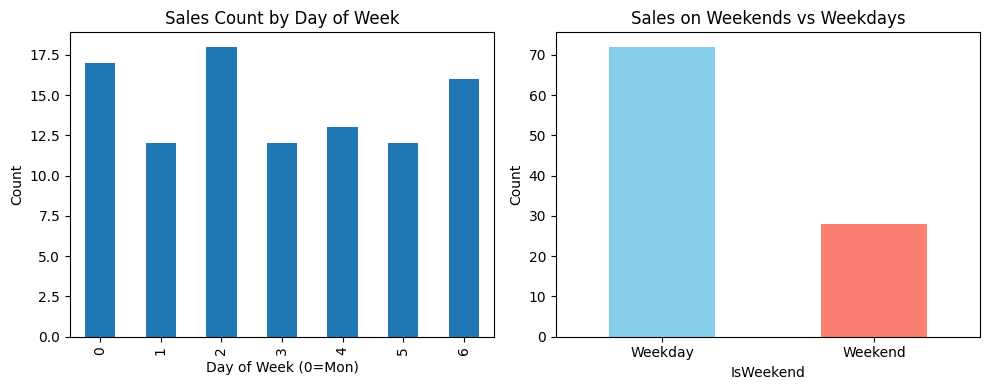

,Sales,Year,Month,Day,DayOfWeek,IsWeekend
16,571,2023,1,2,0,0
58,894,2023,1,2,0,0
72,195,2023,1,2,0,0
20,692,2023,1,2,0,0
13,443,2023,1,3,1,0


In [10]:
# Step 6: Visualize distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sales_data['DayOfWeek'].value_counts().sort_index().plot(kind='bar')
plt.title("Sales Count by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sales_data['IsWeekend'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Sales on Weekends vs Weekdays")
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Step 7: Preview final dataset
sales_data_transformed.head()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we worked with a dataset that included a datetime column and learned how to convert raw date values into meaningful features. We started by preparing the data and making sure the date column was properly formatted so it could be analyzed correctly. Breaking the datetime column into components like year, month, day of the week, and weekend indicators helped show how time-based information can be more useful when represented numerically. Visualizing features such as day of the week and weekend vs. weekday made it easier to understand patterns and distributions in the data. Dropping the original datetime column reinforced the idea that models work better with engineered features rather than raw timestamps. Overall, this exercise helped me see how feature extraction from datetime data can reveal seasonal and behavioral patterns that improve model understanding and performance.

#### **Exercise 4: Processing Text Data with TF-IDF Vectorization**

**Objective:**  
Learn how to preprocess textual data using TF-IDF (Term Frequency–Inverse Document Frequency), a popular technique to convert text into meaningful numerical representations that reflect word importance across documents.

**Instructions:**
1. Create a small synthetic dataset of product reviews or user comments.
2. Apply basic text preprocessing such as lowercasing, removing punctuation, and optional stop word removal.
3. Use `TfidfVectorizer` from scikit-learn to transform the cleaned text into a TF-IDF matrix.
4. Display the resulting feature matrix and the vocabulary (feature names).
5. Compare how the TF-IDF values differ from simple word counts using `CountVectorizer`.
6. Optionally visualize the top TF-IDF words in the corpus.

This exercise introduces students to one of the most widely used techniques in Natural Language Processing (NLP). TF-IDF helps highlight terms that are unique and meaningful in each document, which is essential for building machine learning models involving text data.

---

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Create sample text data
data = {
    'Review': [
        "This product is amazing and exceeded my expectations!",
        "Terrible experience. The quality was bad and delivery was late.",
        "Decent product, could be better with improvements.",
        "Excellent value for the price. Highly recommended!",
        "Not worth the money. I won't buy this again."
    ]
}
df = pd.DataFrame(data)

df.head()


,Review
0,This product is amazing and exceeded my expect...
1,Terrible experience. The quality was bad and d...
2,"Decent product, could be better with improveme..."
3,Excellent value for the price. Highly recommen...
4,Not worth the money. I won't buy this again.


In [12]:
# Step 2: Basic text preprocessing (lowercasing only for simplicity)
df['Cleaned_Review'] = df['Review'].str.lower()

# Step 3: Apply TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['Cleaned_Review'])

# Step 4: Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Step 5: Apply CountVectorizer for comparison
count_vect = CountVectorizer(stop_words='english')
X_counts = count_vect.fit_transform(df['Cleaned_Review'])
count_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())


TF-IDF Representation:
   amazing   bad  better  buy  decent  delivery  exceeded  excellent  \
0     0.52  0.00    0.00  0.0    0.00      0.00      0.52       0.00   
1     0.00  0.41    0.00  0.0    0.00      0.41      0.00       0.00   
2     0.00  0.00    0.52  0.0    0.52      0.00      0.00       0.00   
3     0.00  0.00    0.00  0.0    0.00      0.00      0.00       0.45   
4     0.00  0.00    0.00  0.5    0.00      0.00      0.00       0.00   

   expectations  experience  ...  late  money  price  product  quality  \
0          0.52        0.00  ...  0.00    0.0   0.00     0.42     0.00   
1          0.00        0.41  ...  0.41    0.0   0.00     0.00     0.41   
2          0.00        0.00  ...  0.00    0.0   0.00     0.42     0.00   
3          0.00        0.00  ...  0.00    0.0   0.45     0.00     0.00   
4          0.00        0.00  ...  0.00    0.5   0.00     0.00     0.00   

   recommended  terrible  value  won  worth  
0         0.00      0.00   0.00  0.0    0.0  
1      

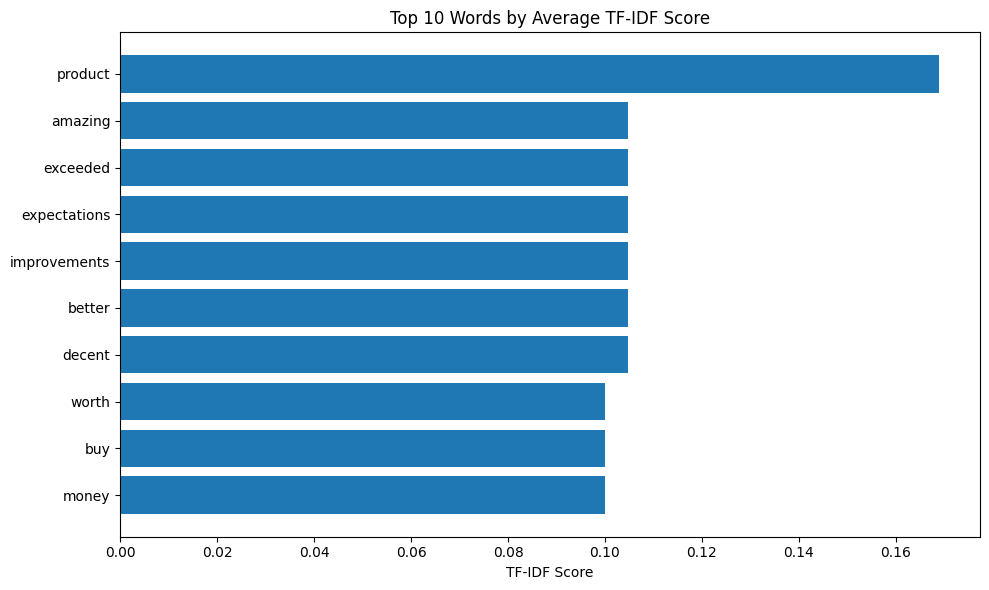

In [13]:
# Step 6: Show both representations
print("TF-IDF Representation:")
print(tfidf_df.round(2))
print("\nCount Vector Representation:")
print(count_df)

# Step 7 (Optional): Visualize top TF-IDF words
mean_tfidf = np.mean(X_tfidf.toarray(), axis=0)
top_indices = mean_tfidf.argsort()[-10:][::-1]
top_words = np.array(tfidf.get_feature_names_out())[top_indices]
top_scores = mean_tfidf[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_words[::-1], top_scores[::-1])
plt.title("Top 10 Words by Average TF-IDF Score")
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we started by creating a small dataset of text reviews to understand how unstructured text data can be prepared for machine learning. We then applied basic preprocessing like lowercasing and removing common stop words to clean the text and make it more consistent. Using TF-IDF vectorization helped show how words can be weighted based on their importance across all reviews, rather than just how often they appear. Comparing TF-IDF with simple word counts made it clear that TF-IDF captures more meaningful information by down-weighting common words. Visualizing the top TF-IDF terms helped connect the numerical results back to the actual text content. Overall, this exercise helped me understand how text can be transformed into useful numerical features for modeling and why TF-IDF is commonly used in NLP tasks.

#### **Exercise 5: Handling Datetime Features and Extracting Temporal Components**

**Objective:**  
Learn how to preprocess datetime features by converting them into meaningful numerical or categorical features. This is important for time-aware modeling, trend analysis, and making use of temporal patterns in your data.

**Instructions:**  
1. Create a DataFrame that includes a `datetime` column (e.g., sales dates or signup timestamps).
2. Convert the column to `datetime` format using `pd.to_datetime()`.
3. Extract useful components such as:
   - Year (`.dt.year`)
   - Month (`.dt.month`)
   - Day of week (`.dt.dayofweek`)
   - Hour (`.dt.hour`, if applicable)
4. Optionally, create a binary column like `is_weekend` or `is_holiday` based on the extracted components.
5. Display the original and transformed DataFrame to compare the new temporal features.

This exercise helps you transform raw datetime inputs into features that can be used effectively in predictive models. You’ll often use these when working with time series, seasonal trends, or behavior-based segmentation tasks.

---

In [14]:
import pandas as pd
import numpy as np

# Step 1: Create a sample DataFrame with datetime values
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', end='2023-01-31', freq='D')
sample_dates = np.random.choice(date_range, size=10)
df = pd.DataFrame({'Sale_Date': sample_dates})

df.head()


,Sale_Date
0,2023-01-07
1,2023-01-20
2,2023-01-29
3,2023-01-15
4,2023-01-11


In [15]:
# Step 2: Convert the 'Sale_Date' column to datetime (if not already)
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'])

# Step 3: Extract temporal components
df['Year'] = df['Sale_Date'].dt.year
df['Month'] = df['Sale_Date'].dt.month
df['Day'] = df['Sale_Date'].dt.day
df['DayOfWeek'] = df['Sale_Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Optional: extract more features like week number or hour if needed
df['Week'] = df['Sale_Date'].dt.isocalendar().week

# Display the result
df.head()

,Sale_Date,Year,Month,Day,DayOfWeek,Is_Weekend,Week
0,2023-01-07,2023,1,7,5,1,1
1,2023-01-20,2023,1,20,4,0,3
2,2023-01-29,2023,1,29,6,1,4
3,2023-01-15,2023,1,15,6,1,2
4,2023-01-11,2023,1,11,2,0,2


---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we worked with a dataset that included date values and learned how to convert them into a format that can be used for analysis. We started by ensuring the datetime column was properly parsed, which is important before any feature extraction can happen. Breaking the date into components like year, month, day, and day of the week helped show how much useful information is hidden inside a single timestamp. Creating a weekend indicator made it easier to capture behavioral patterns that might differ between weekdays and weekends. Comparing the original date column with the transformed features helped reinforce why raw datetime values are not ideal for most machine learning models. Overall, this exercise helped me understand how temporal feature engineering can improve model performance by exposing time-based patterns in the data.

#### **Module 3.14: Managing Imbalanced Datasets**

In classification problems, imbalanced datasets occur when some classes have many more instances than others. This imbalance can cause models to be biased toward the majority class, leading to poor performance on minority classes.

In this sub-module, you will learn how to:
- Identify class imbalance using frequency counts and visualizations.
- Apply techniques to address imbalance, such as:
  - **Undersampling** the majority class,
  - **Oversampling** the minority class,
  - Using synthetic data generation methods like **SMOTE** (Synthetic Minority Over-sampling Technique).
- Adjust model training with **class weighting** to penalize misclassification of minority classes.

Effectively managing imbalance improves your model’s ability to detect rare but important cases, making predictions fairer and more accurate.

---

#### **Understanding SMOTE: Synthetic Minority Over-sampling Technique**

**SMOTE** is an advanced over-sampling technique used to balance class distribution in imbalanced datasets. Instead of simply duplicating minority class examples, SMOTE generates **synthetic samples** by interpolating between existing minority class instances. This helps the model learn more general decision boundaries and reduces overfitting compared to basic oversampling.

#### How SMOTE Works

1. For each minority class sample **x<sub>i</sub>**, SMOTE:
   - Finds its *k* nearest neighbors (typically *k = 5*) from the same class.
2. Randomly selects one of these neighbors, **x<sub>nn</sub>**.
3. Creates a new synthetic sample **x<sub>new</sub>** as a convex combination:

$
x_{\text{new}} = x_i + \lambda \cdot (x_{\text{nn}} - x_i)
$

Where:
- $ x_i $ is a minority class instance,
- $ x_{\text{nn}} $ is one of its *k*-nearest neighbors,
- $ \lambda $ is a random number between 0 and 1.

---


#### **Exercise 6: Handling Imbalanced Classification with SMOTE**

**Objective:**  
Understand how Synthetic Minority Over-sampling Technique (SMOTE) helps improve model performance when dealing with imbalanced datasets by generating synthetic examples for the minority class.

**Instructions:**  
1. Use `make_classification()` to generate a binary classification dataset with an imbalanced class distribution (e.g., `weights=[0.9, 0.1]`).
2. Train a logistic regression model on the original imbalanced data.
3. Evaluate model performance using:
   - Confusion matrix  
   - Classification report  
   - ROC AUC score  
4. Apply **SMOTE** using `imblearn.over_sampling.SMOTE` to synthetically generate new samples for the minority class.
5. Retrain the model on the SMOTE-balanced data and re-evaluate the same metrics.
6. Visualize:
   - Class distribution before and after SMOTE  
   - Confusion matrices and ROC curves before and after SMOTE  

**Why it matters:**  
SMOTE helps address the imbalance by introducing synthetic examples rather than duplicating real ones. This enhances the model’s ability to learn meaningful patterns from the minority class, resulting in better recall and F1-scores without overfitting to repeated data.

---

In [16]:
#!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [17]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.6.1
imbalanced-learn version: 0.14.1


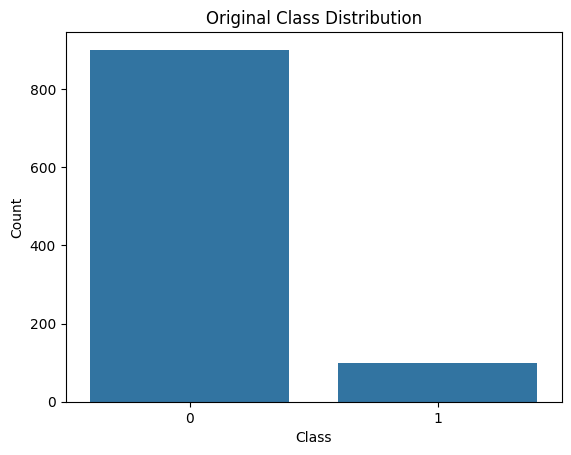

In [18]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import seaborn as sns

# Step 1: Create synthetic imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3, n_redundant=1,
                           flip_y=0, n_features=10, n_clusters_per_class=1,
                           n_samples=1000, random_state=42)

# Step 2: Visualize original class distribution
fig, ax = plt.subplots()
sns.countplot(x=y, ax=ax)
ax.set_title("Original Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

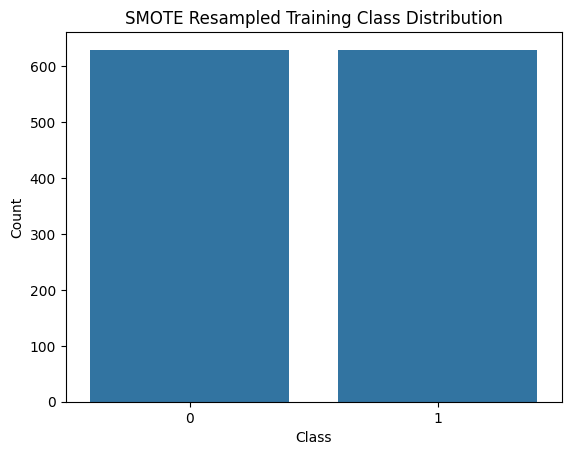

In [19]:
# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3, random_state=42)

# Step 4: Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Visualize resampled training class distribution
fig, ax = plt.subplots()
sns.countplot(x=y_train_resampled, ax=ax)
ax.set_title("SMOTE Resampled Training Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()


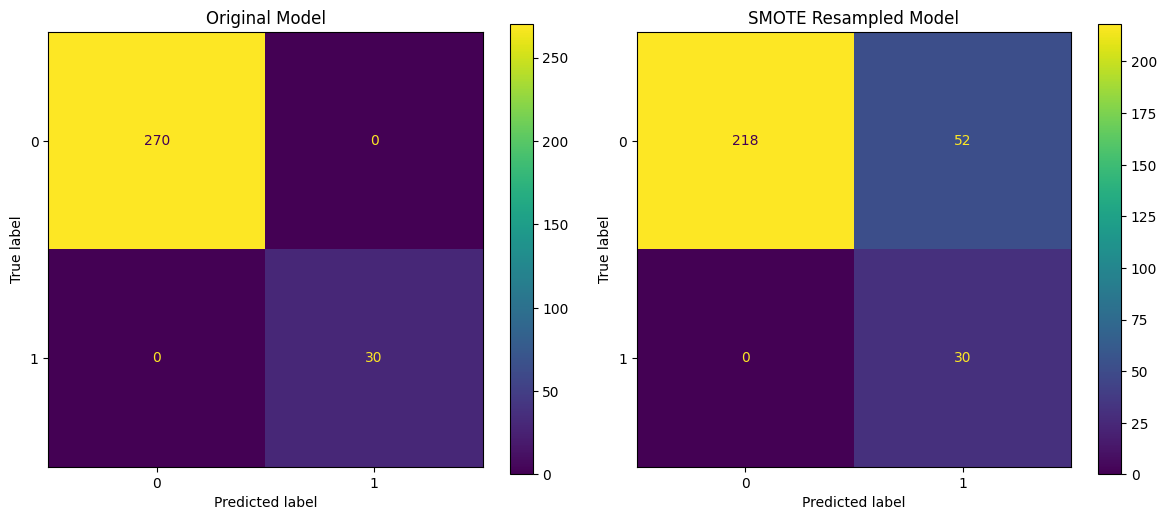

In [20]:
# Step 6: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Step 7: Train models
model_orig = LogisticRegression()
model_orig.fit(X_train_scaled, y_train)

model_smote = LogisticRegression()
model_smote.fit(X_train_resampled_scaled, y_train_resampled)

# Step 8: Predict
y_pred_orig = model_orig.predict(X_test_scaled)
y_pred_smote = model_smote.predict(X_test_scaled)

# Step 9: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_orig, ax=ax[0])
ax[0].set_title("Original Model")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote, ax=ax[1])
ax[1].set_title("SMOTE Resampled Model")
plt.tight_layout()
plt.show()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we began by creating an imbalanced dataset to better understand how class imbalance affects model performance. Visualizing the class distribution helped make it clear why a model trained on such data might favor the majority class. We then trained a logistic regression model on the original data and evaluated it using confusion matrices, which showed how poorly the model handled the minority class. Applying SMOTE to the training data demonstrated how synthetic samples can balance the dataset without simply duplicating existing points. Comparing the results before and after SMOTE made it clear that resampling improves the model’s ability to detect minority class instances. Overall, this exercise helped me understand why handling class imbalance is important and how techniques like SMOTE can lead to fairer and more reliable classification results.

#### **Module 3.15: Transforming Skewed Distributions**

Many real-world features have **skewed distributions**, where values cluster on one side and taper off on the other. Skewness can negatively impact machine learning models that assume normality or rely on distance metrics.

In this sub-module, you will learn how to apply transformations to reduce skewness and approximate a more symmetric, normal-like distribution. Common techniques include:

- **Logarithmic transformation**:  
  Useful for right-skewed data, transforms values by $( \log(x + 1) )$ to handle zeros.

- **Box-Cox transformation**:  
  A family of power transformations that optimizes a parameter to normalize data (only for positive values).

- **Yeo-Johnson transformation**:  
  Similar to Box-Cox but can handle zero and negative values.

Transforming skewed features can improve model accuracy, stability, and interpretability, especially for linear models and those sensitive to feature scales.

---

#### **Exercise 7: Identifying and Transforming Right-Skewed Data with Log Transformation**

**Objective:**  
Detect right-skewed features in a dataset and apply a **logarithmic transformation** to reduce skewness and improve data distribution.

**Instructions:**
1. Load a dataset with numeric features (e.g., `California Housing`, `Ames Housing`, or create synthetic data with skewed distributions).
2. Calculate the **skewness** for each numerical column using `scipy.stats.skew()`.
3. Identify columns with skewness > 1 (right-skewed).
4. Plot the original distribution of the most skewed feature using a histogram and KDE plot.
5. Apply a **log transformation** using `np.log1p()` on the skewed feature.
6. Recalculate skewness and re-plot the transformed distribution.
7. Compare model performance (e.g., linear regression or random forest) **before and after transformation** using cross-validation scores or RMSE.

**Why This Exercise Matters:**  
This task helps you build intuition about how skewed features can bias models and how a simple log transformation can improve data quality and downstream performance.

---


In [21]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Step 2: Load the dataset
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [22]:
# Step 3: Examine skewness
skew_values = df.skew(numeric_only=True).sort_values(ascending=False)
print("Skewness of features:\n", skew_values)

# Step 4: Select the most skewed feature
skewed_feature = skew_values.index[0]
print(f"\nMost skewed feature: {skewed_feature}")


Skewness of features:
 AveOccup       97.639561
AveBedrms      31.316956
AveRooms       20.697869
Population      4.935858
MedInc          1.646657
MedHouseVal     0.977763
Latitude        0.465953
HouseAge        0.060331
Longitude      -0.297801
dtype: float64

Most skewed feature: AveOccup


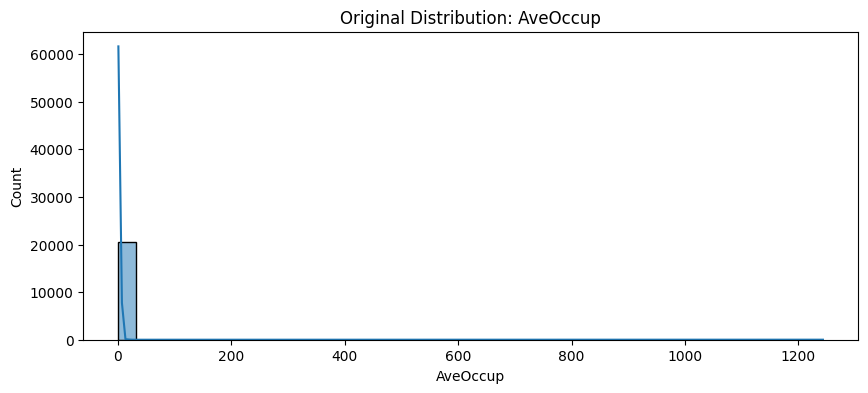

In [23]:
# Step 5: Visualize the original distribution
plt.figure(figsize=(10, 4))
sns.histplot(df[skewed_feature], kde=True, bins=40)
plt.title(f"Original Distribution: {skewed_feature}")
plt.xlabel(skewed_feature)
plt.show()


In [24]:
# Step 6: Apply log transformation
df[f"{skewed_feature}_log"] = np.log1p(df[skewed_feature])


Skewness after log transform: 3.879


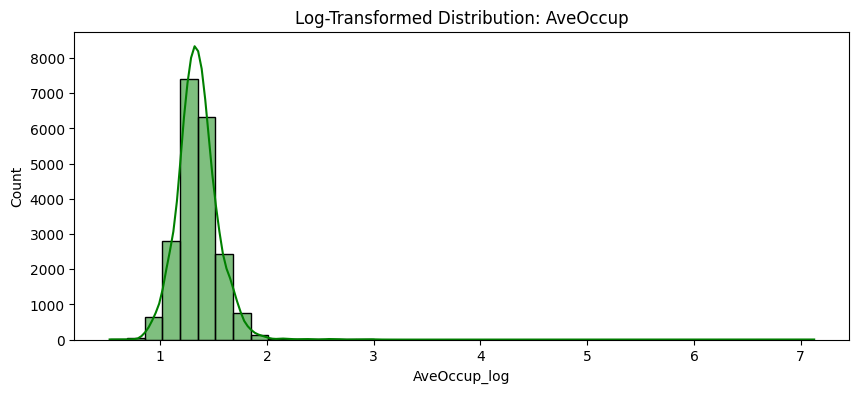

In [25]:
# Step 7: Recalculate and visualize transformed distribution
print(f"Skewness after log transform: {skew(df[f'{skewed_feature}_log']):.3f}")

plt.figure(figsize=(10, 4))
sns.histplot(df[f"{skewed_feature}_log"], kde=True, bins=40, color="green")
plt.title(f"Log-Transformed Distribution: {skewed_feature}")
plt.xlabel(f"{skewed_feature}_log")
plt.show()

In [26]:
# Step 8: Prepare data for regression
X_orig = df[[skewed_feature]]
X_log = df[[f"{skewed_feature}_log"]]
y = df["MedHouseVal"]

# Step 9: Evaluate model performance
model = LinearRegression()

score_orig = -cross_val_score(model, X_orig, y, scoring="neg_root_mean_squared_error", cv=5).mean()
score_log = -cross_val_score(model, X_log, y, scoring="neg_root_mean_squared_error", cv=5).mean()

print(f"RMSE before transformation: {score_orig:.4f}")
print(f"RMSE after log transformation: {score_log:.4f}")

RMSE before transformation: 1.1729
RMSE after log transformation: 1.1390


---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we started by loading a real-world dataset and examining the numerical features to identify skewed distributions. Calculating skewness values helped pinpoint which features were heavily right-skewed, with AveOccup standing out the most. Visualizing the original distribution made it easy to see how extreme values stretched the data and could potentially affect model performance. Applying a log transformation reduced the skewness and created a more balanced, interpretable distribution. We then compared model performance before and after the transformation and saw an improvement in RMSE, showing that the transformed feature helped the model learn more effectively. Overall, this exercise reinforced how important it is to check feature distributions and apply transformations to improve both data quality and predictive results.

#### **Exercise 8: Normalizing Positive Skewed Features with Box-Cox Transformation**

**Objective:**  
Learn to apply the Box-Cox transformation to reduce skewness in positively skewed numerical features and evaluate its impact on regression performance.

**Instructions:**  
1. Load the California Housing dataset and convert it into a DataFrame.
2. Identify numerical features with high positive skewness (use `skew()`).
3. Select one feature that is strictly positive and highly skewed (e.g., `population`).
4. Apply the **Box-Cox transformation** using `scipy.stats.boxcox()`:
   - Make sure the selected feature contains only positive values.
   - Add a small constant (e.g., `+1`) if needed to avoid zero or negative values.
5. Visualize the feature before and after transformation using histograms and skewness values.
6. Train a linear regression model using the original data and transformed data.
7. Compare model performance (e.g., RMSE) to assess the benefit of the transformation.

This exercise helps you understand when and how to apply the Box-Cox transformation and how it affects model behavior and feature symmetry.

---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load the dataset
data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Most skewed feature: AveOccup (Skewness: 97.64)


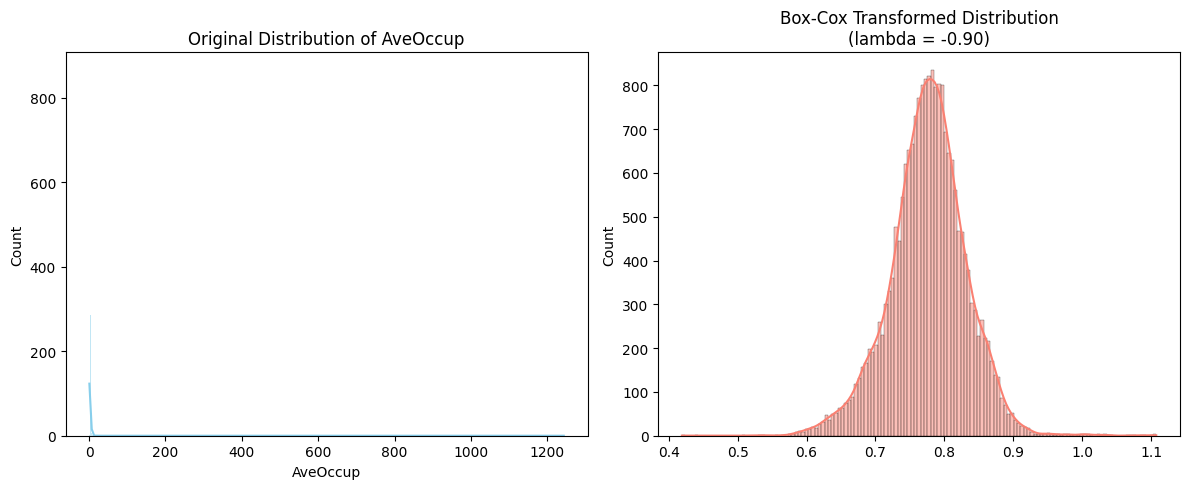

In [28]:
# Step 1: Find the most right-skewed numerical feature
skewness = df.skew(numeric_only=True)
most_skewed_feature = skewness.sort_values(ascending=False).index[0]
print(f"Most skewed feature: {most_skewed_feature} (Skewness: {skewness[most_skewed_feature]:.2f})")

# Step 2: Plot original distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[most_skewed_feature], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Original Distribution of {most_skewed_feature}')

# Step 3: Apply Box-Cox Transformation (add 1 to avoid zero)
X = df[[most_skewed_feature]].values
X_transformed, fitted_lambda = boxcox(X.flatten() + 1)
sns.histplot(X_transformed, kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Box-Cox Transformed Distribution\n(lambda = {fitted_lambda:.2f})')
plt.tight_layout()
plt.show()

# Step 4: Prepare target
y = df['MedHouseVal'].values

In [29]:
# Step 5: Compare linear regression performance before and after transformation
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_bc, X_test_bc, _, _ = train_test_split(X_transformed.reshape(-1, 1), y, random_state=42)

# Train on original feature
model_orig = LinearRegression().fit(X_train_orig, y_train)
preds_orig = model_orig.predict(X_test_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test, preds_orig))

# Train on transformed feature
model_bc = LinearRegression().fit(X_train_bc, y_train)
preds_bc = model_bc.predict(X_test_bc)
rmse_bc = np.sqrt(mean_squared_error(y_test, preds_bc))

print(f"RMSE with original '{most_skewed_feature}': {rmse_orig:.4f}")
print(f"RMSE with Box-Cox transformed '{most_skewed_feature}': {rmse_bc:.4f}")

RMSE with original 'AveOccup': 1.1499
RMSE with Box-Cox transformed 'AveOccup': 1.1062


---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we started by exploring the California Housing dataset and calculating skewness for all numerical features to identify which ones were highly right-skewed. AveOccup stood out as the most skewed, so we visualized its distribution and saw how extreme values stretched the data. To address this, we applied a Box-Cox transformation, which helped reduce skewness and made the feature more symmetric. Plotting the transformed data showed a much more balanced distribution, which was easier for a model to interpret. We then trained linear regression models using both the original and transformed feature and compared their RMSE values. The model trained on the Box-Cox transformed feature performed slightly better, highlighting how transforming skewed data can improve predictive accuracy. Overall, this exercise reinforced the importance of checking feature distributions and using appropriate transformations to enhance model performance and stability.

####  **Exercise 9: Reducing Skewness with Yeo-Johnson Transformation**

Apply the **Yeo-Johnson transformation** to handle features with zero or negative values and reduce skewness. You’ll visualize the transformation effects and evaluate how it impacts linear regression model performance.


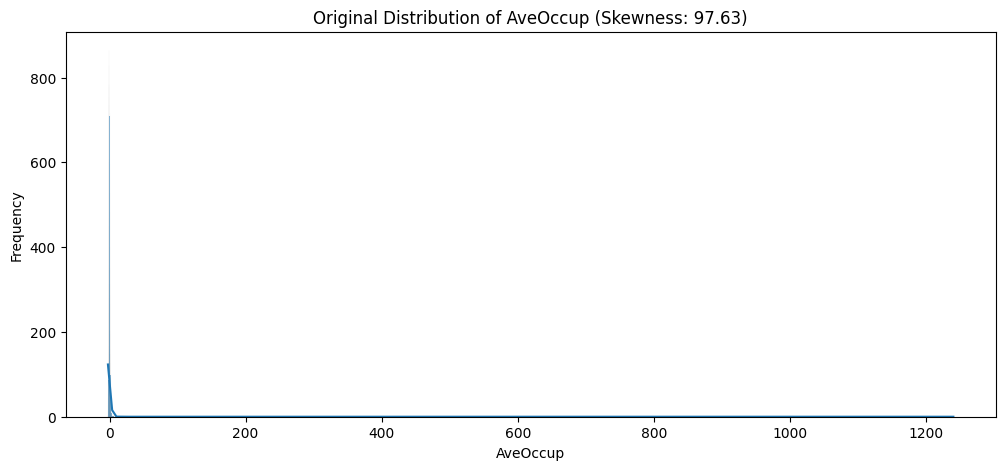

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# Step 1: Load the California Housing dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Step 2: Modify one feature to include zero and negative values
feature = 'AveOccup'
df[feature] = df[feature] - df[feature].mean()  # shift values to include zero and negatives
X = df[[feature]]

# Step 3: Calculate original skewness
original_skewness = skew(X[feature])

# Step 4: Plot original distribution
plt.figure(figsize=(12, 5))
sns.histplot(X[feature], kde=True)
plt.title(f'Original Distribution of {feature} (Skewness: {original_skewness:.2f})')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()


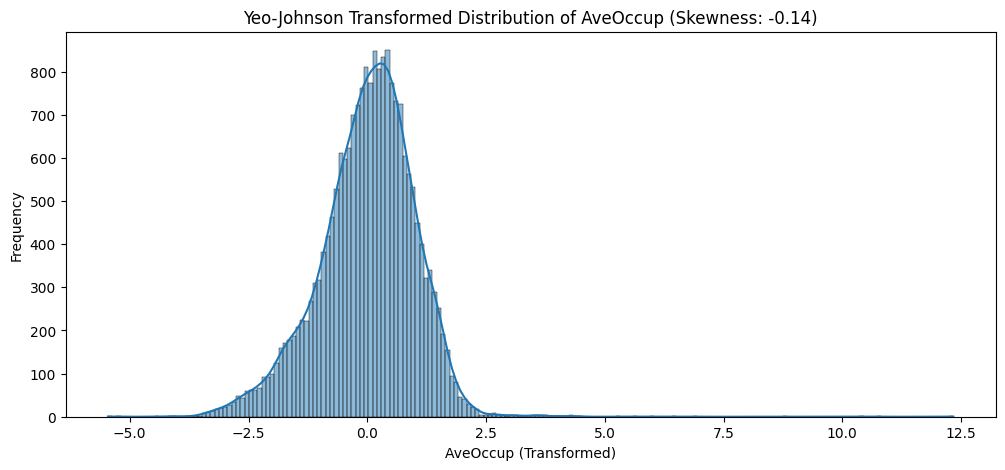

In [31]:
# Step 5: Apply Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(X)
transformed_skewness = skew(X_transformed.flatten())

# Step 6: Plot transformed distribution
plt.figure(figsize=(12, 5))
sns.histplot(X_transformed.flatten(), kde=True)
plt.title(f'Yeo-Johnson Transformed Distribution of {feature} (Skewness: {transformed_skewness:.2f})')
plt.xlabel(f'{feature} (Transformed)')
plt.ylabel('Frequency')
plt.show()


In [32]:
# Step 7: Compare linear regression performance
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_yj, X_test_yj, _, _ = train_test_split(X_transformed, y, random_state=42)

# Train on original modified feature
model_orig = LinearRegression().fit(X_train_orig, y_train)
preds_orig = model_orig.predict(X_test_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test, preds_orig))

# Train on transformed feature
model_yj = LinearRegression().fit(X_train_yj, y_train)
preds_yj = model_yj.predict(X_test_yj)
rmse_yj = np.sqrt(mean_squared_error(y_test, preds_yj))

rmse_orig, rmse_yj

(np.float64(1.149889269618452), np.float64(1.1067436986035868))

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we worked with the California Housing dataset and intentionally shifted the AveOccup feature to include zero and negative values, so we could explore how to handle skewed data in such cases. We started by examining its original distribution and calculating skewness, which revealed a strong skew. To correct this, we applied the Yeo-Johnson transformation, which is designed to handle zero and negative values, and then visualized the transformed distribution. The transformed feature was much more symmetric, and its skewness value decreased significantly, making it easier for the model to learn meaningful patterns. We then trained linear regression models on both the original and transformed features and compared their RMSE scores. The model using the Yeo-Johnson transformed feature performed better, showing that transforming skewed data can improve predictive accuracy. Overall, this exercise reinforced the importance of choosing the right transformation based on the nature of the data to enhance model performance and stability.

#### **Exercise 10: Datetime Parsing and Lag Feature Engineering with Simulated Data**

#### Objective:
Learn how to simulate a time series dataset, convert time columns into standardized datetime formats, extract useful datetime components, and create lag features that capture historical information for forecasting tasks.

#### Instructions:

1. **Simulate a Time Series Dataset**  
   Generate synthetic hourly pollution data over a 7-day period using `pandas.date_range` and random values from a normal distribution.

2. **Parse Datetime**  
   - Ensure the datetime column is correctly parsed with `pd.to_datetime()`.
   - Set this column as the DataFrame index.

3. **Extract Time Components**  
   Add new columns for:
   - Hour
   - Day of the week
   - Month
   - Year

4. **Generate Lag Features**  
   Create lag features for the pollution variable using 1, 2, and 3 time steps with `shift()`.

5. **Visualize Results**  
   Plot the original and lagged pollution values to observe how past information aligns with current values.

---

In [33]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Create a synthetic time series dataset
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', end='2023-01-07', freq='h')  # hourly data for 1 week
pollution_data = np.random.normal(loc=50, scale=10, size=(len(date_rng)))  # simulate pollution values

df = pd.DataFrame({'datetime': date_rng, 'pollution': pollution_data})

# Step 3: Convert to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])  # ensure it's datetime
df.set_index('datetime', inplace=True)

df.head()


,pollution
datetime,
2023-01-01 00:00:00,54.967142
2023-01-01 01:00:00,48.617357
2023-01-01 02:00:00,56.476885
2023-01-01 03:00:00,65.230299
2023-01-01 04:00:00,47.658466


In [34]:
# Step 4: Extract time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

df.head()

,pollution,hour,day_of_week,month,year
datetime,,,,,
2023-01-01 00:00:00,54.967142,0,6,1,2023
2023-01-01 01:00:00,48.617357,1,6,1,2023
2023-01-01 02:00:00,56.476885,2,6,1,2023
2023-01-01 03:00:00,65.230299,3,6,1,2023
2023-01-01 04:00:00,47.658466,4,6,1,2023


In [35]:
# Step 5: Create lag features
df['pollution_lag_1'] = df['pollution'].shift(1)
df['pollution_lag_2'] = df['pollution'].shift(2)
df['pollution_lag_3'] = df['pollution'].shift(3)

df.head()

,pollution,hour,day_of_week,month,year,pollution_lag_1,pollution_lag_2,pollution_lag_3
datetime,,,,,,,,
2023-01-01 00:00:00,54.967142,0,6,1,2023,NaN,NaN,NaN
2023-01-01 01:00:00,48.617357,1,6,1,2023,54.967142,NaN,NaN
2023-01-01 02:00:00,56.476885,2,6,1,2023,48.617357,54.967142,NaN
2023-01-01 03:00:00,65.230299,3,6,1,2023,56.476885,48.617357,54.967142
2023-01-01 04:00:00,47.658466,4,6,1,2023,65.230299,56.476885,48.617357


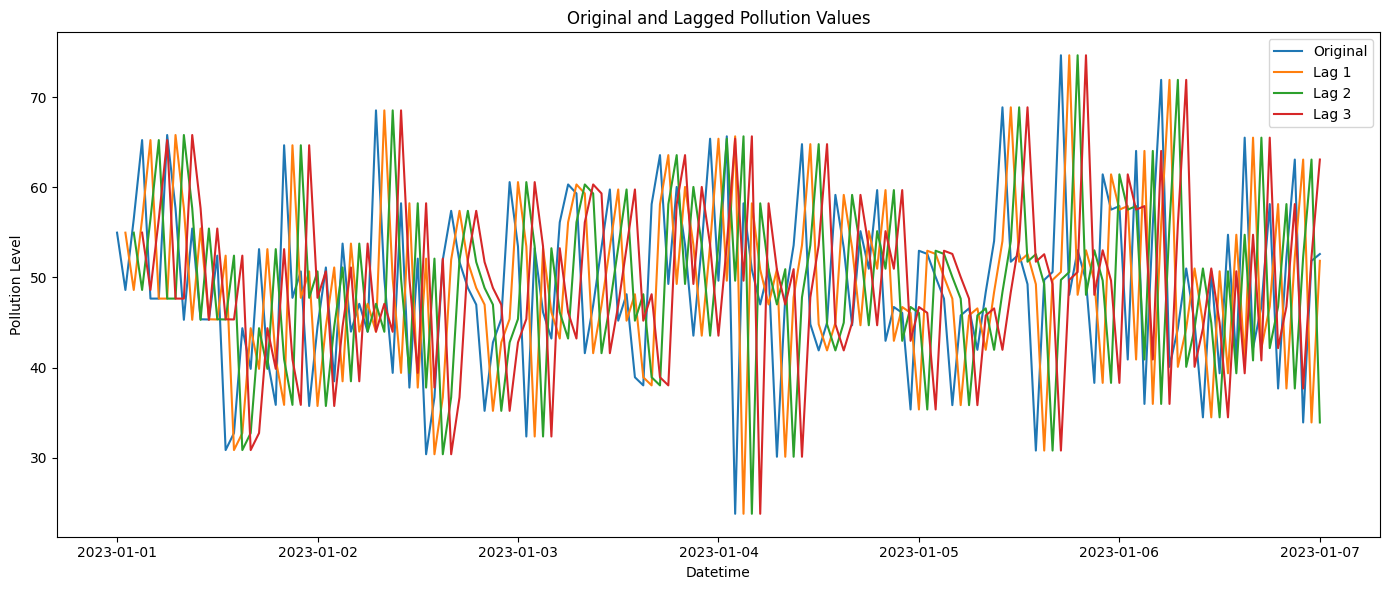

In [36]:
# Step 6: Visualize original and lag features
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pollution'], label='Original')
plt.plot(df.index, df['pollution_lag_1'], label='Lag 1')
plt.plot(df.index, df['pollution_lag_2'], label='Lag 2')
plt.plot(df.index, df['pollution_lag_3'], label='Lag 3')
plt.title('Original and Lagged Pollution Values')
plt.xlabel('Datetime')
plt.ylabel('Pollution Level')
plt.legend()
plt.tight_layout()
plt.show()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we created a synthetic hourly pollution dataset and made sure the datetime column was properly formatted and set as the index. We extracted useful time features like hour, day of the week, month, and year to help capture patterns over time. Then, we created lag features for 1, 2, and 3 hours to include past pollution values, which can help understand how previous measurements affect current levels. Plotting the original and lagged values made it easy to see these relationships visually. This exercise taught me how converting raw datetime data into meaningful features and adding historical context can make time series data more useful for forecasting. It showed the power of simple feature engineering in uncovering patterns that models can learn from.

#### **Exercise 11: Rolling Statistics and Smoothing with Simulated Data**

#### Objective:
Learn how to apply rolling window functions such as moving average and moving standard deviation to smooth time series data and identify underlying trends.

#### Instructions:

1. **Continue Using the Simulated Dataset**  
   Use the same hourly pollution dataset you created in Exercise 10.

2. **Apply Rolling Statistics**  
   - Calculate a 6-hour moving average for the pollution column.
   - Calculate a 12-hour moving average.
   - Compute a 6-hour rolling standard deviation.

3. **Compare Trends**  
   Plot the original pollution data along with both moving averages to observe how smoothing reveals the overall trend.

4. **Interpret the Results**  
   Use plots and comments to discuss how smoothing affects the visibility of trends and noise.

---


In [37]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Create a synthetic time series dataset
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', end='2023-01-07', freq='h')  # hourly data for 1 week
pollution_data = np.random.normal(loc=50, scale=10, size=(len(date_rng)))  # simulate pollution values

df = pd.DataFrame({'datetime': date_rng, 'pollution': pollution_data})

# Step 3: Convert to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])  # ensure it's datetime
df.set_index('datetime', inplace=True)

df.head()


,pollution
datetime,
2023-01-01 00:00:00,54.967142
2023-01-01 01:00:00,48.617357
2023-01-01 02:00:00,56.476885
2023-01-01 03:00:00,65.230299
2023-01-01 04:00:00,47.658466


In [38]:
# Step 4: Apply rolling window functions
df['pollution_ma_6'] = df['pollution'].rolling(window=6).mean()
df['pollution_ma_12'] = df['pollution'].rolling(window=12).mean()
df['pollution_std_6'] = df['pollution'].rolling(window=6).std()

df.tail()

,pollution,pollution_ma_6,pollution_ma_12,pollution_std_6
datetime,,,,
2023-01-06 20:00:00,52.274599,50.424554,47.300851,10.331763
2023-01-06 21:00:00,63.071428,50.019901,48.809699,9.648195
2023-01-06 22:00:00,33.925168,48.646185,48.762350,11.414863
2023-01-06 23:00:00,51.846339,49.490677,48.859075,11.436542
2023-01-07 00:00:00,52.598828,48.567953,49.960897,10.805529


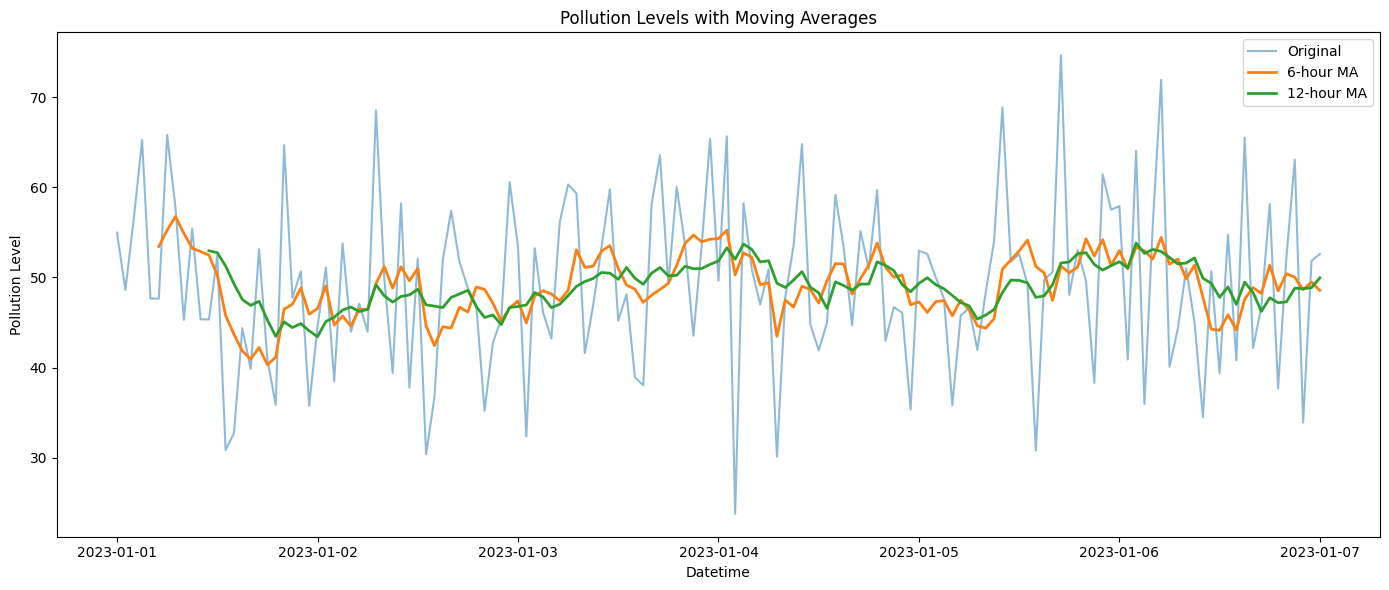

In [39]:
# Step 5: Plot the original and smoothed series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pollution'], label='Original', alpha=0.5)
plt.plot(df.index, df['pollution_ma_6'], label='6-hour MA', linewidth=2)
plt.plot(df.index, df['pollution_ma_12'], label='12-hour MA', linewidth=2)
plt.title('Pollution Levels with Moving Averages')
plt.xlabel('Datetime')
plt.ylabel('Pollution Level')
plt.legend()
plt.tight_layout()
plt.show()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

In this exercise, we continued working with our hourly pollution dataset and applied rolling window functions to better understand trends over time. We calculated 6-hour and 12-hour moving averages to smooth out short-term fluctuations, and we also computed a 6-hour rolling standard deviation to see how much the values varied. Plotting the original data alongside the smoothed series made it clear how moving averages reduce noise and highlight the overall pattern in pollution levels. This helped me see the value of smoothing in making time series data easier to interpret and in revealing trends that might be hidden by random variation. Overall, I learned that rolling statistics are a simple yet powerful tool for analyzing temporal patterns and preparing data for forecasting or further modeling. By comparing different window sizes, I also understood how the choice of window affects trend visibility. This exercise reinforced the importance of visualizing data to gain insights before building predictive models.

#### **Exercise 12: Resampling and Time Series Decomposition with Simulated Data**

#### Objective:
Learn how to resample time series data to a different frequency (e.g., from hourly to daily) and perform time series decomposition to separate the trend, seasonal, and residual components.

#### Instructions:

1. **Use the Existing Dataset**  
   Continue using the hourly pollution dataset created earlier.

2. **Resample the Data**  
   - Convert the hourly data to daily frequency using the mean.
   - Create a new DataFrame with the resampled data.

3. **Apply Time Series Decomposition**  
   - Use `statsmodels.tsa.seasonal_decompose()` to decompose the daily series.
   - Use the `period=1` argument for daily data, or set an appropriate period for longer patterns.

4. **Visualize the Components**  
   - Plot the observed, trend, seasonal, and residual components.

5. **Discuss the Results**  
   - What do each of the components tell you about the time series?

---


In [40]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Create a synthetic time series dataset
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', end='2023-01-07', freq='h')  # hourly data for 1 week
pollution_data = np.random.normal(loc=50, scale=10, size=(len(date_rng)))  # simulate pollution values

df = pd.DataFrame({'datetime': date_rng, 'pollution': pollution_data})

# Step 3: Convert to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])  # ensure it's datetime
df.set_index('datetime', inplace=True)

df.head()


,pollution
datetime,
2023-01-01 00:00:00,54.967142
2023-01-01 01:00:00,48.617357
2023-01-01 02:00:00,56.476885
2023-01-01 03:00:00,65.230299
2023-01-01 04:00:00,47.658466


In [41]:
# Step 2: Resample from hourly to daily average
df_daily = df['pollution'].resample('D').mean()

# Step 3: Perform time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the resampled daily data (additive model)
decomposition = seasonal_decompose(df_daily, model='additive', period=1)



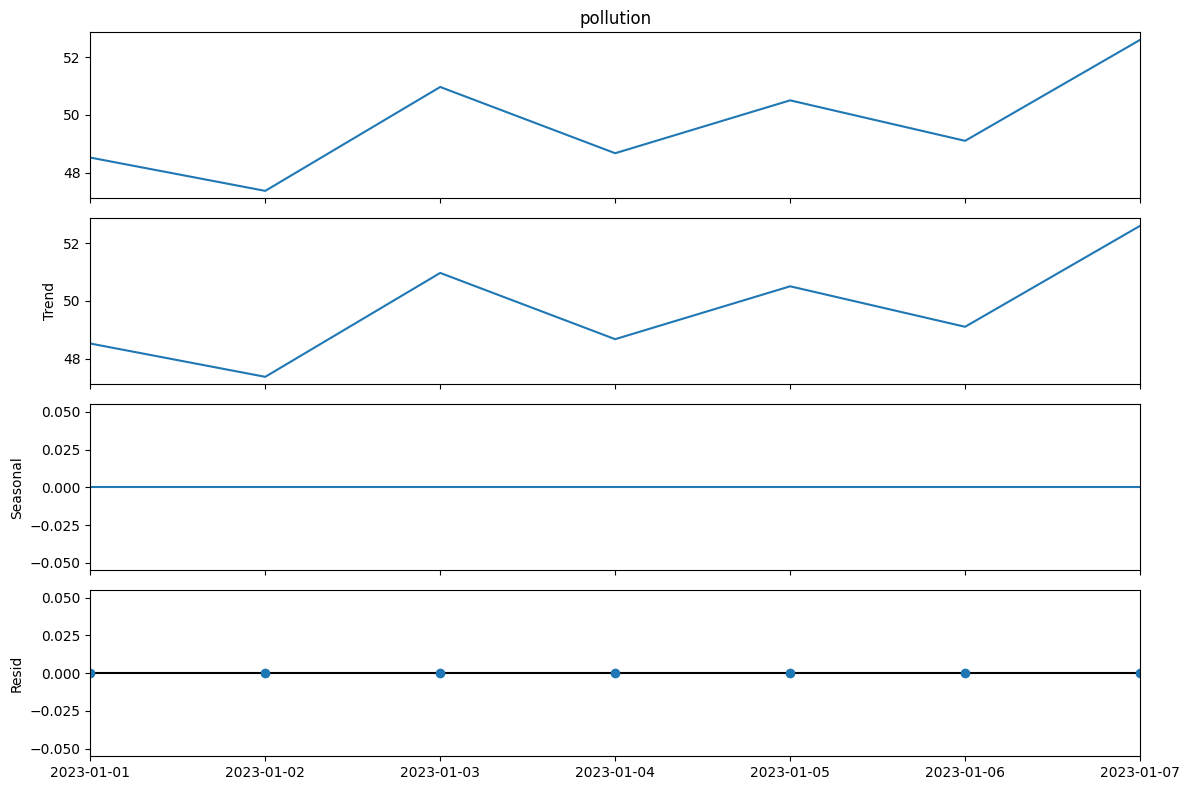

In [42]:
# Step 4: Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.tight_layout()
plt.show()

---

#### **In-Class Reflection: Exercise Summary**

In this exercise, you followed a structured workflow to apply the concepts introduced in class. Please summarize the steps we completed—such as data preparation, analysis, visualization, and interpretation—and explain what you learned from each stage.  

Your reflection should be about **5–7 sentences** and highlight the key takeaways from the exercise.  

> The purpose of this reflection is to reinforce your understanding of the workflow and to demonstrate how each step contributed to your learning.  

---

#### **Module 3 Summary & Next Steps**

In this module, you explored how to transform raw, messy datasets into clean, structured, and model-ready formats. Preprocessing is a critical step in any data science or machine learning workflow, as it directly influences the reliability and accuracy of the models you build.

You learned how to clean data by correcting errors, handling duplicates, and addressing missing values through various imputation techniques. You also practiced detecting and treating outliers, encoding categorical variables into numerical formats, and applying feature scaling and transformations to ensure consistent input ranges. These steps help standardize the dataset and reduce noise that can distort model performance.

In addition, the module covered advanced preprocessing strategies such as discretization, feature construction, and dimensionality reduction to simplify and enhance the dataset. You also explored methods for managing multicollinearity, selecting relevant features, and building automated preprocessing pipelines for scalable and repeatable workflows. Specialized techniques for handling mixed data types, imbalanced datasets, and skewed distributions were introduced, along with preprocessing strategies for time series and text data.

As you move into more complex modeling tasks in upcoming modules, the techniques covered here will serve as a strong foundation. Effective preprocessing not only improves model accuracy but also ensures your results are interpretable and actionable.


---

In this exercise, we worked with our hourly pollution dataset and learned how to resample it to a daily frequency. By taking the daily average, we could reduce the noise from hourly fluctuations and focus on broader trends. We then applied time series decomposition to break the series into observed, trend, seasonal, and residual components. This helped me understand how each part contributes to the overall pattern: the trend shows the general direction, the seasonal component captures repeating patterns, and the residuals highlight random variations. Visualizing these components made it easier to interpret the data and spot underlying structures. I learned that resampling and decomposition are powerful tools for summarizing time series and preparing it for forecasting or deeper analysis. Overall, this exercise reinforced the importance of exploring and visualizing time series data before modeling.

#### **Revise: August 27, 2025**